# Testing the CT Current Sensor

In [1]:
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

## Simplify analysis with a function

In [2]:
# I'm defining an admittedly messy function to analyze the output from the 
# current sensor and create a nice plot with some useful metrics.

def analyze_sensor_data(data, sample_time, title=None):
    # Perform all kinds of caculations on the input data
    t = np.linspace(0, sample_time, len(data))
    high_ix = argrelextrema(data, np.greater, order=2)
    low_ix = argrelextrema(data, np.less, order=2)
    dt = sample_time / (len(data) * 1000)
    per = dt * np.concatenate([np.diff(high_ix), np.diff(low_ix)], axis=1).mean()
    freq = 1/per
    v_high = data[high_ix].mean()
    v_low = data[low_ix].mean()
    v_avg = (v_high + v_low) / 2
    v_rms = 0.3536 * (v_high - v_low)
    I = (100 / 333) * v_rms
    p = 120 * I

    # Create a plot and put lines on it
    fig = plt.figure(figsize=(7, 4))
    plt.plot(t, data, c='lightseagreen')       # The measured voltages
    plt.axhline(v_high, lw=1, c='k', ls='--')  # The average upper bound
    plt.axhline(v_low, lw=1, c='k', ls='--')   # The average lower bound
    plt.axhline(v_avg, lw=1, c='k', ls='--')   # Smack in the middle is the v_offset
    
    # Display useful metrics next to the plot
    plt.figtext(1, 0.75, fontdict={'size': 12}, s=f'Freq = {round(freq, 2)} Hz')
    plt.figtext(1, 0.68, fontdict={'size': 12}, s=f'v_high = {round(v_high, 2)} mV')
    plt.figtext(1, 0.61, fontdict={'size': 12}, s=f'v_low = {round(v_low, 2)} mV')
    plt.figtext(1, 0.54, fontdict={'size': 12}, s=f'offset = {round(v_avg, 2)} mV')
    plt.figtext(1, 0.47, fontdict={'size': 12}, s=f'v_pp = {round(v_high - v_low, 2)} mV')
    plt.figtext(1, 0.40, fontdict={'size': 12}, s=f'I = {round(I, 2)} A')
    plt.figtext(1, 0.33, fontdict={'size': 12}, s=f'P = {round(p, 2)} W')
    
    # Labels are good
    plt.xlabel('Elapsed Time (ms)')
    plt.ylabel('Voltage across CT (mv)')
    if title:
        plt.title(title)
    
    plt.tight_layout()
    plt.show()

## Start testing

### Hot Water Kettle (Rated for 1500 W)

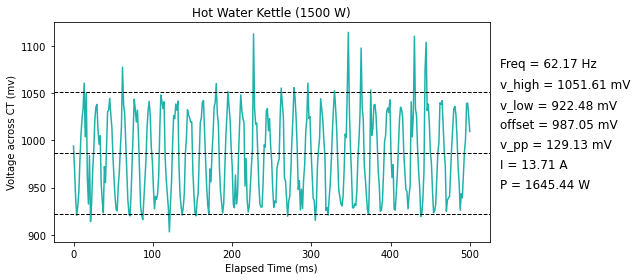

In [3]:
with open('./data/kettle-1500W.txt') as f:
    kettle_data = np.array([float(val) for val in f])
analyze_sensor_data(kettle_data, 500, title='Hot Water Kettle (1500 W)')

### Toaster (Rated for 900 W)

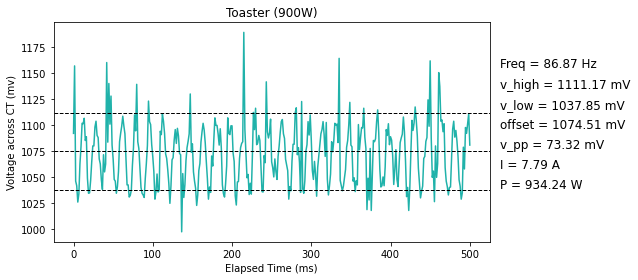

In [4]:
with open('./data/toaster-900W.txt') as f:
    toaster_data = np.array([float(val) for val in f])
analyze_sensor_data(toaster_data, 500, title='Toaster (900W)')

### Rice Cooker (Rated for 350 W)

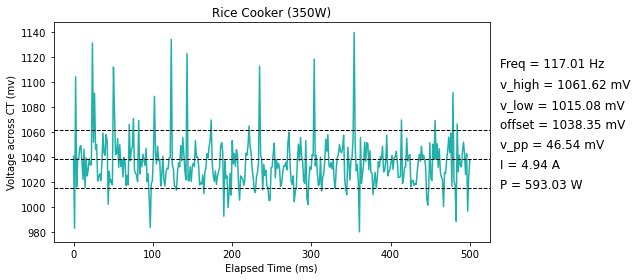

In [5]:
with open('./data/rice-cooker-350W.txt') as f:
    rice_cooker_data = np.array([float(val) for val in f])
analyze_sensor_data(rice_cooker_data, 500, title='Rice Cooker (350W)')

### Compact Fluorescent Light Bulb (Rated for 13 W)

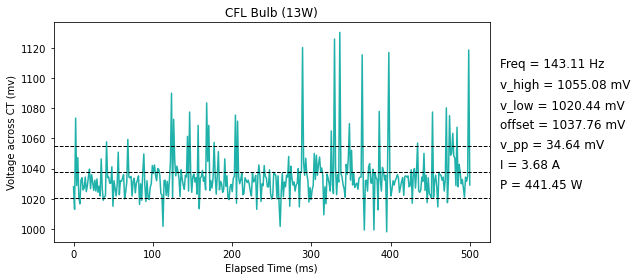

In [6]:
with open('./data/cfl-bulb-13W.txt') as f:
    cfl_bulb_data = np.array([float(val) for val in f])
analyze_sensor_data(cfl_bulb_data, 500, title='CFL Bulb (13W)')